# Однофакторный анализ связи меток кред и фрод дефолта target.class с данными таблиц Фед ресурса efrsfdu базы данных VLS-MDM-DB MDM_Main по фичам (часть 5)

- bad_reasons_closed - плохое завершение предыдущих договоров   
- good_reasons_closed - хорошее завершение предыдущих договоров  
- not_determined_reasons_closed - неопределенное завершение предыдущих договоров  

Входные данные data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи

In [1]:
import pandas as pd

In [2]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [3]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))

Размер считанных данных target_class with mdm features- (85798, 39)


In [4]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/analysis_features_part5.xlsx"
writer = ExcelWriter(name)

In [5]:
# target_features.head(2)

#### Теперь формируем выборки для фрод и кред дефолта

In [6]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению
target_frod_early = Target(type='фрод', target_data=target_features, by_application=False) # это приведенный фрод дефолт на самый первое обращение
target_cred = Target(type='кред', target_data=target_features)# это кред дефолт, макс по обращению

target_frod.print_param()
target_frod_early.print_param()
target_cred.print_param()

target_frod.data = target_frod.data.reset_index()
target_cred.data = target_cred.data.reset_index()



Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4708 из 63131 (7.46%)

Параметры обработанной таблицы портфеля рисков  приведенный фрод дефолт на самое первое обращение:
	фрод дефолт = 1  у выборки 4179 из 61793 (6.76%)

Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1977 из 43723 (4.52%)


In [7]:
# target_frod.data.head(2)

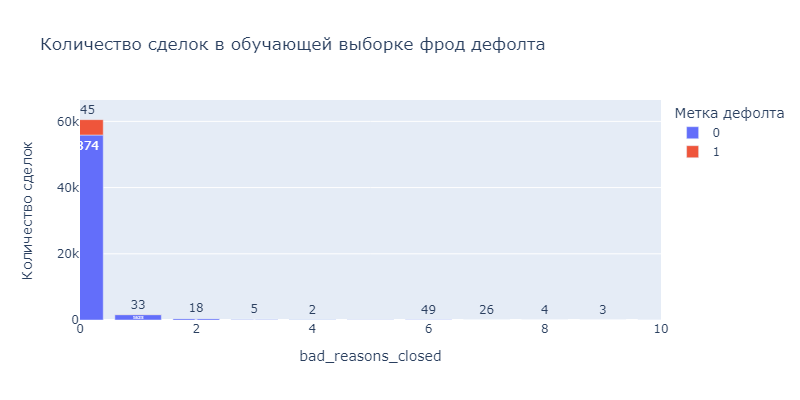

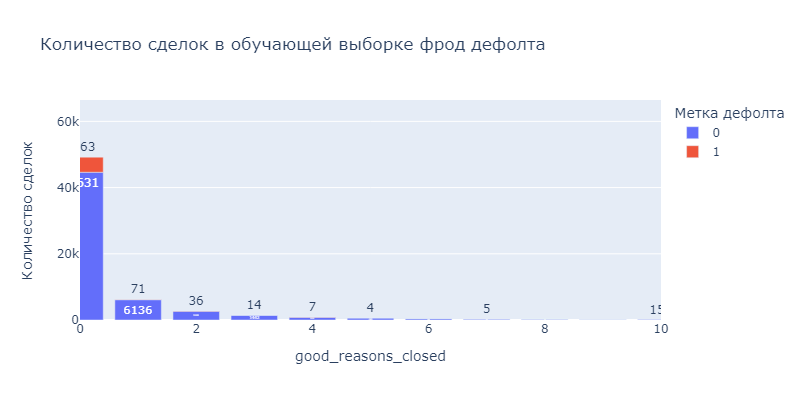

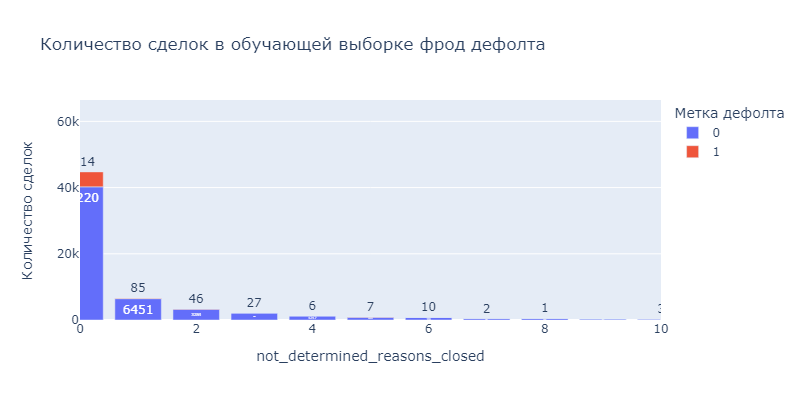

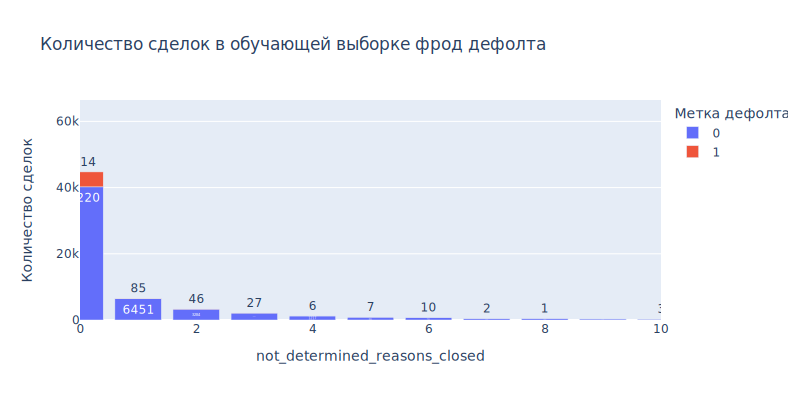

In [28]:
plot_features_bar(target_frod.data, 'bad_reasons_closed', x_range =[0, 10])
plot_features_bar(target_frod.data, 'good_reasons_closed', x_range =[0, 10])
plot_features_bar(target_frod.data, 'not_determined_reasons_closed', x_range =[0, 10])

In [9]:
#  статиcтика по фичам
stat = target_frod.data['bad_reasons_closed'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'bad_reasons_closed':'frod_bad_reasons_closed'})
stat = stat.append(target_frod.data['good_reasons_closed'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'good_reasons_closed':'frod_good_reasons_closed'}))
stat = stat.append(target_frod.data['not_determined_reasons_closed'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'not_determined_reasons_closed':'frod_determined_reasons_closed'}))

stat.to_excel(writer, sheet_name='stat_features')
stat


,min,max,mean,std
frod_bad_reasons_closed,0.0,31.0,0.083192,0.666302
frod_good_reasons_closed,0.0,141.0,0.803282,3.511079
frod_determined_reasons_closed,0.0,223.0,1.502178,5.710274


In [10]:
#  статиcтика по фичам
stat = target_cred.data['bad_reasons_closed'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'bad_reasons_closed':'frod_bad_reasons_closed'})
stat = stat.append(target_cred.data['good_reasons_closed'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'good_reasons_closed':'frod_good_reasons_closed'}))
stat = stat.append(target_cred.data['not_determined_reasons_closed'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'not_determined_reasons_closed':'frod_determined_reasons_closed'}))

stat.to_excel(writer, sheet_name='stat_features')
stat

,min,max,mean,std
frod_bad_reasons_closed,0.0,30.0,0.084326,0.669851
frod_good_reasons_closed,0.0,116.0,0.705167,2.798480
frod_determined_reasons_closed,0.0,206.0,1.540699,5.415634


## newLogRegression 

### Дефолтные сделки (фрод метка)

{'rocauc': 0.52, 'accuracy': 0.11, 'recall': 0.99}
{'intercept': -0.0111, 'coef': array([-0.2189])}


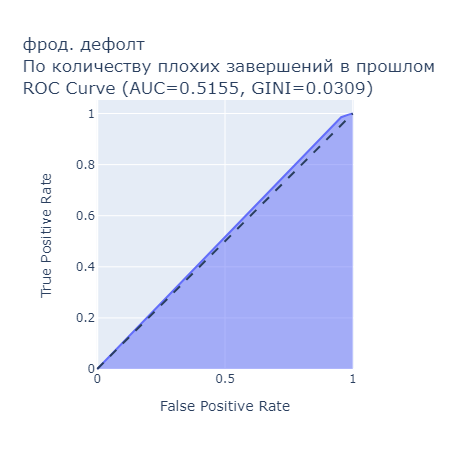

In [11]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['bad_reasons_closed']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству плохих завершений в прошлом')

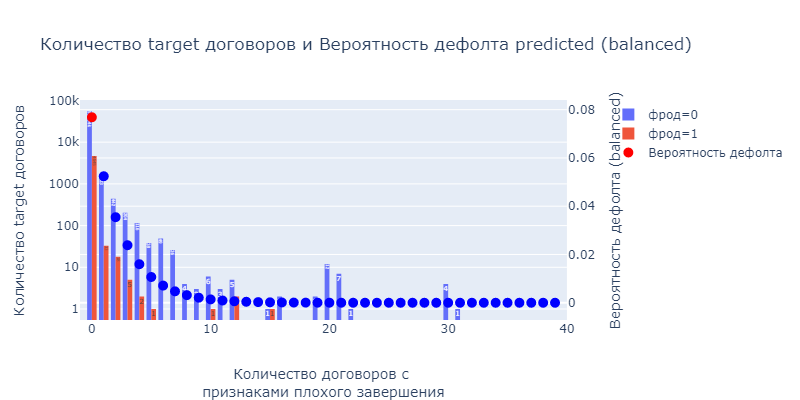

In [12]:
y_pred, y_prob = log.predict(np.arange(0, 40))
df_second = pd.DataFrame({'X':np.arange(0, 40), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='bad_reasons_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 40], 
                height= 400, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('bad_reasons_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

{'rocauc': 0.61, 'accuracy': 0.29, 'recall': 0.97}
{'intercept': -0.4245, 'coef': array([-2.5989])}


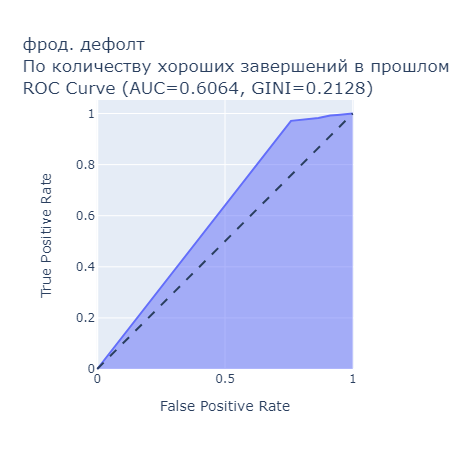

In [13]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['good_reasons_closed']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству хороших завершений в прошлом')

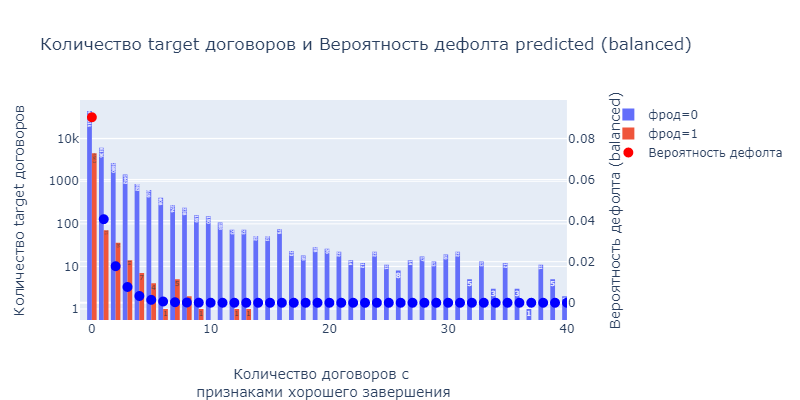

In [14]:
y_pred, y_prob = log.predict(np.arange(0, 100))
df_second = pd.DataFrame({'X':np.arange(0, 100), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='good_reasons_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 40], 
                height= 400, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('good_reasons_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

{'rocauc': 0.64, 'accuracy': 0.36, 'recall': 0.96}
{'intercept': -0.5399, 'coef': array([-2.8699])}


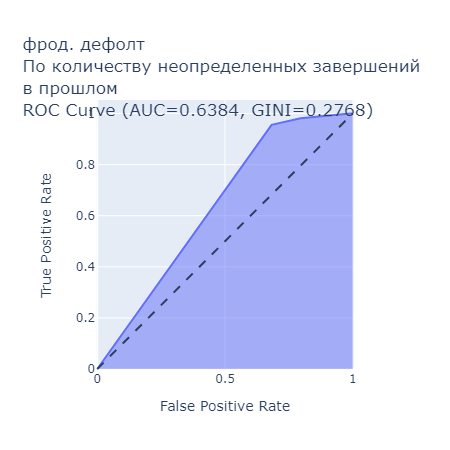

In [15]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['not_determined_reasons_closed']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству неопределенных завершений' + '<br>' +'в прошлом')

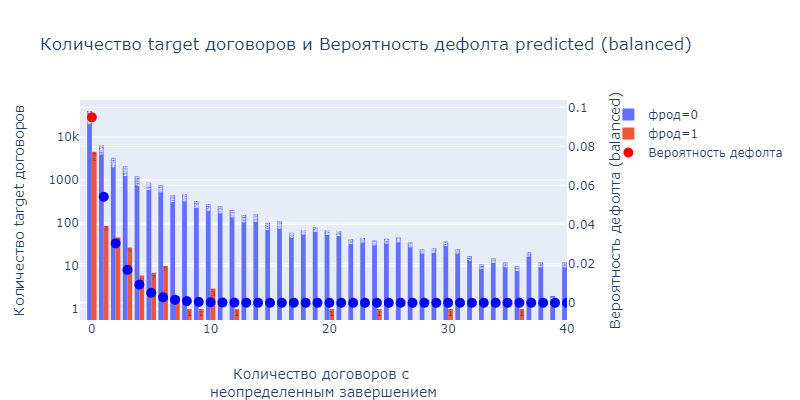

In [16]:
y_pred, y_prob = log.predict(np.arange(0, 100))
df_second = pd.DataFrame({'X':np.arange(0, 100), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_frod.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='not_determined_reasons_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 40], 
                height= 400, width =800, 
                classes = ['фрод=0', 'фрод=1'], 
                x_title = get_feature_name('not_determined_reasons_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

сразу от трех

{'rocauc': 0.67, 'accuracy': 0.43, 'recall': 0.94}
{'intercept': -0.6924, 'coef': array([ 0.096 , -1.7587, -2.152 ])}


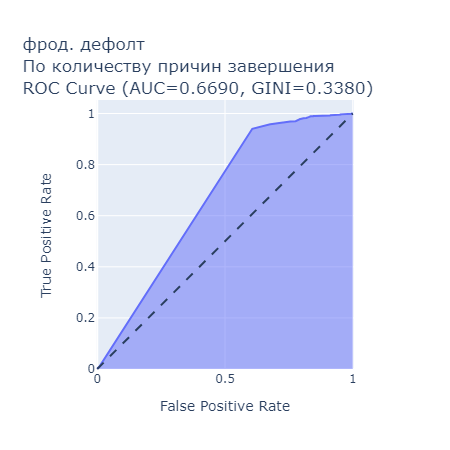

In [17]:
type = target_frod.type

X_raw = np.asarray(target_frod.data[['bad_reasons_closed', 'good_reasons_closed', 'not_determined_reasons_closed']])
y = np.asarray(target_frod.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству причин завершения')

In [18]:
#  коэффициенты лог регрессии
pd.DataFrame({'reason':['bad_reasons_closed', 'good_reasons_closed', 'not_determined_reasons_closed'], 'coef':log.model.coef_[0]}).sort_values(by='coef')

,reason,coef
2,not_determined_reasons_closed,-2.152020
1,good_reasons_closed,-1.758661
0,bad_reasons_closed,0.095979


### Дефолтные сделки (кред метка)

{'rocauc': 0.5, 'accuracy': 0.91, 'recall': 0.04}
{'intercept': -0.0017, 'coef': array([0.0622])}


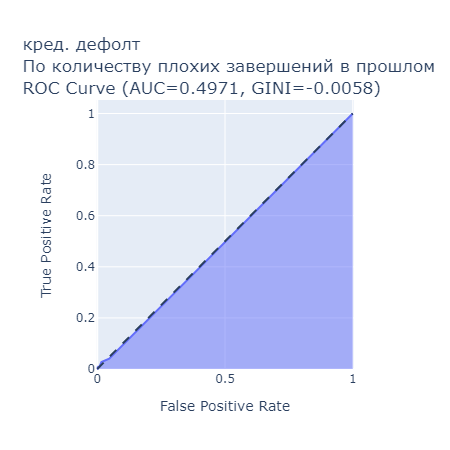

In [19]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['bad_reasons_closed']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству плохих завершений в прошлом')

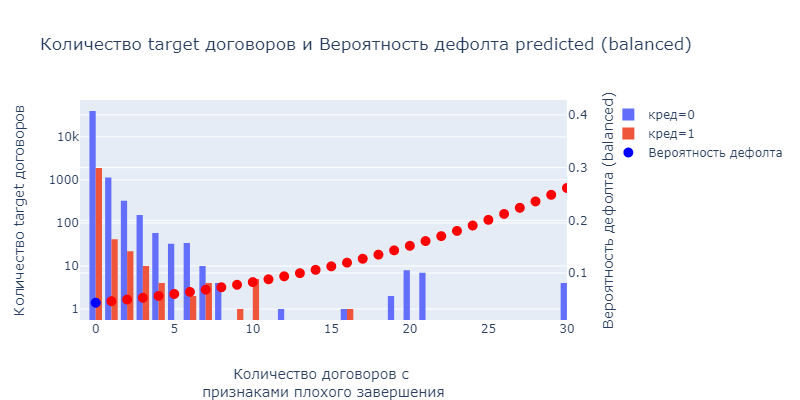

In [20]:
y_pred, y_prob = log.predict(np.arange(0, 40))
df_second = pd.DataFrame({'X':np.arange(0, 40), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='bad_reasons_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 30], 
                height= 400, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('bad_reasons_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

{'rocauc': 0.56, 'accuracy': 0.26, 'recall': 0.88}
{'intercept': -0.029, 'coef': array([-0.34])}


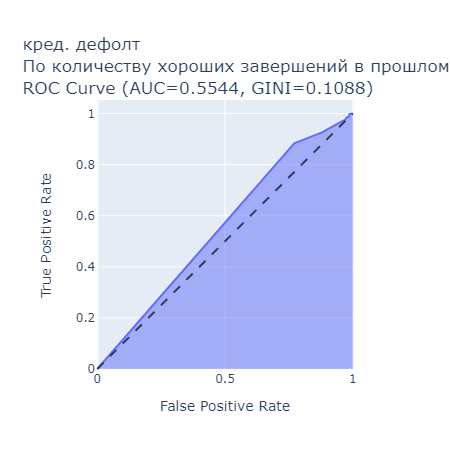

In [21]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['good_reasons_closed']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству хороших завершений в прошлом')

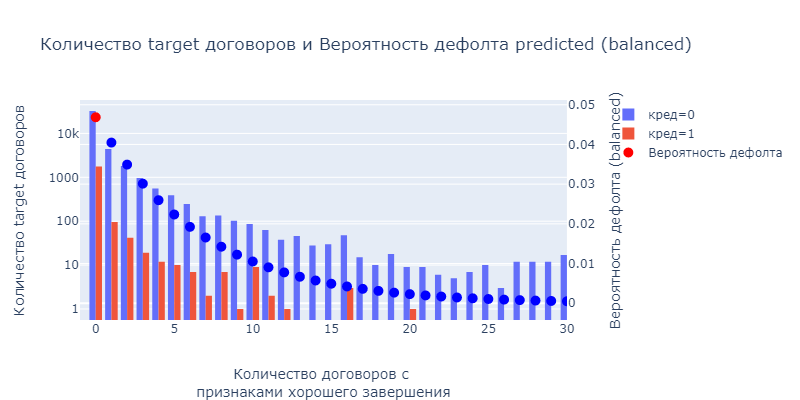

In [22]:
y_pred, y_prob = log.predict(np.arange(0, 40))
df_second = pd.DataFrame({'X':np.arange(0, 40), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='good_reasons_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 30], 
                height= 400, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('good_reasons_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

{'rocauc': 0.59, 'accuracy': 0.36, 'recall': 0.85}
{'intercept': -0.0569, 'coef': array([-0.4954])}


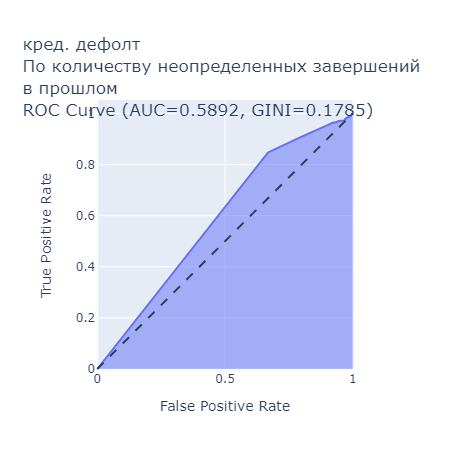

In [23]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['not_determined_reasons_closed']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству неопределенных завершений' + '<br>' +'в прошлом')

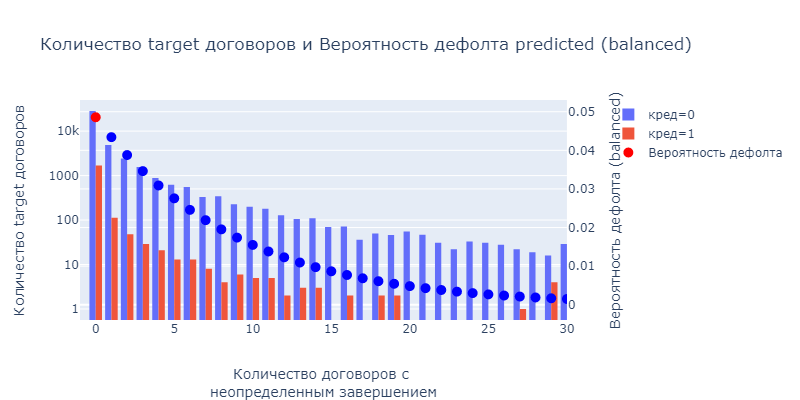

In [24]:
y_pred, y_prob = log.predict(np.arange(0, 40))
df_second = pd.DataFrame({'X':np.arange(0, 40), 'y_pred':y_pred, 'y_prob':y_prob})

kwargs = dict(df = target_cred.data.copy(), df_second=df_second,
              title='Количество target договоров и Вероятность дефолта predicted (balanced)', 
                x_feature='not_determined_reasons_closed', y_feature='Приложение', color = 'Метка дефолта', 
                x_range=[-1, 30], 
                height= 400, width =800, 
                classes = ['кред=0', 'кред=1'], 
                x_title = get_feature_name('not_determined_reasons_closed', 'title'), y_title='Количество target договоров', 
                y_title_second = 'Вероятность дефолта (balanced)')
    
fig_predictions = create_plot(cpPredictionsOnData, **kwargs)
fig_predictions.show('png' if need_svg else '')

сразу от трех

{'rocauc': 0.58, 'accuracy': 0.29, 'recall': 0.89}
{'intercept': -0.0788, 'coef': array([ 0.1759, -0.2183, -0.4781])}


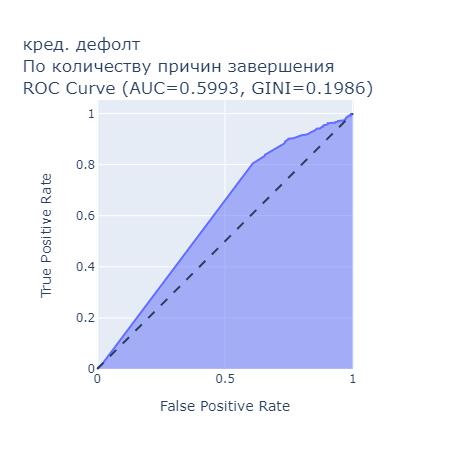

In [25]:
type = target_cred.type

X_raw = np.asarray(target_cred.data[['bad_reasons_closed', 'good_reasons_closed', 'not_determined_reasons_closed']])
y = np.asarray(target_cred.data['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По количеству причин завершения')

In [26]:
#  коэффициенты лог регрессии
pd.DataFrame({'reason':['bad_reasons_closed', 'good_reasons_closed', 'not_determined_reasons_closed'], 'coef':log.model.coef_[0]}).sort_values(by='coef')

,reason,coef
2,not_determined_reasons_closed,-0.478122
1,good_reasons_closed,-0.218272
0,bad_reasons_closed,0.175873


In [27]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()